# Homework 2
### Pierre-Antoine Desplaces, Anaïs Ladoy, Lou Richard

In [1]:
# Import libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import json

### Question 1

Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the [details page](https://www.topuniversities.com/universities/ecole-polytechnique-fédérale-de-lausanne-epfl).
Store the resulting dataset in a pandas DataFrame and answer the following questions:
- Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
- Answer the previous question aggregating the data by (c) country and (d) region.

Plot your data using bar charts and describe briefly what you observed.


In [2]:
URL1 = 'https://www.topuniversities.com/university-rankings/world-university-rankings/2018'
URL2 = 'http://timeshighereducation.com/world-university-rankings/2018/world-ranking'

In [3]:
# Do the request
r = requests.get(URL1)

Inspecting the DOM of the website, we find that the ranking datas are stored in a text file at https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt as we can see here :

In [4]:
# 357051.txt
id1 = r.text.find("357051.txt")
r.text[id1-88:id1+11]

'"rank_url":"https:\\/\\/www.topuniversities.com\\/sites\\/default\\/files\\/qs-rankings-data\\/357051.txt"'

We thus request the datas from this URL, keeping only the 200 first elements.

In [5]:
data_QS_URL = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt'
data_QS = requests.get(data_QS_URL)
#create the dataframe
df_QS = pd.DataFrame(data_QS.json()['data'][:200])

We now keep the relevant columns.

In [6]:
# select only the useful columns
df_ranking = pd.DataFrame({"University" : df_QS.title,\
                           "Rank" : df_QS.rank_display,\
                           "Score" : df_QS.score,\
                           "Country": df_QS.country,\
                           "Region": df_QS.region, "URL" : df_QS.url},\
                          columns = ['Rank', 'University', 'Score', 'Country', 'Region', 'URL'])

In [7]:
df_ranking

,Rank,University,Score,Country,Region,URL
0,1,Massachusetts Institute of Technology (MIT),100,United States,North America,/universities/massachusetts-institute-technolo...
1,2,Stanford University,98.7,United States,North America,/universities/stanford-university
2,3,Harvard University,98.4,United States,North America,/universities/harvard-university
3,4,California Institute of Technology (Caltech),97.7,United States,North America,/universities/california-institute-technology-...
4,5,University of Cambridge,95.6,United Kingdom,Europe,/universities/university-cambridge
5,6,University of Oxford,95.3,United Kingdom,Europe,/universities/university-oxford
6,7,UCL (University College London),94.6,United Kingdom,Europe,/universities/ucl-university-college-london
7,8,Imperial College London,93.7,United Kingdom,Europe,/universities/imperial-college-london
8,9,University of Chicago,93.5,United States,North America,/universities/university-chicago
9,10,ETH Zurich - Swiss Federal Institute of Techno...,93.3,Switzerland,Europe,/universities/eth-zurich-swiss-federal-institu...


We observe that the 200th university has a rank = 201, this is because there is no 198th (we can see that the last 195th should be the 197th, and the next rank is 199).

We now have to get the number of faculties and students for each university. For this, we have to go the page of the university on the topuniversities website, and collect these information. Inspecting these webapges, we find that the number of faculty members is in the div number of the div total faculty, the number of international faculty members is in the div number of the div inter faculty, the number of students is in the div number of the div total students, and finally the number of international students is in the div number of the div total inter.

In [12]:
# fetch the university informations from its webpage
def get_numbers_of(url):
    # get the data from the university page
    r = requests.get('https://www.topuniversities.com'+url)
    soup = BeautifulSoup(r.text, "html.parser")
    # find the corresponding tag
    try:
        staff = soup.find('div', class_="total faculty").find('div', class_="number").string
        staff = int(str(staff).replace('\n', "").replace(",", ""))
    except:
        staff = np.nan
    try :
        inter_staff = soup.find('div', class_="inter faculty").find('div', class_="number").string
        inter_staff = int(str(inter_staff).replace('\n', "").replace(",", ""))
    except:
        inter_staff = np.nan
    try : 
        students = soup.find('div', class_="total student").find('div', class_="number").string
        students = int(str(students).replace('\n', "").replace(",", ""))
    except:
        students = np.nan
    try : 
        inter_students = soup.find('div', class_="total inter").find('div', class_="number").string
        inter_students = int(str(inter_students).replace('\n', "").replace(",", ""))
    except:
        inter_students = np.nan
    
    return staff, inter_staff, students, inter_students

We fetch the results into new columns in our dataframe.

In [13]:
df_ranking['Faculty Members'], \
df_ranking['International Faculty Members'], \
df_ranking['Total Students'], \
df_ranking['International Students'] = zip(*df_ranking['URL'].map(get_numbers_of))

We can now remove the URL columns, as it is not useful anymore.

In [14]:
df_ranking = df_ranking.drop('URL', axis=1)
df_ranking

,Rank,University,Score,Country,Region,Faculty Members,International Faculty Members,Total Students,International Students
0,1,Massachusetts Institute of Technology (MIT),100,United States,North America,2982.0,1679.0,11067.0,3717.0
1,2,Stanford University,98.7,United States,North America,4285.0,2042.0,15878.0,3611.0
2,3,Harvard University,98.4,United States,North America,4350.0,1311.0,22429.0,5266.0
3,4,California Institute of Technology (Caltech),97.7,United States,North America,953.0,350.0,2255.0,647.0
4,5,University of Cambridge,95.6,United Kingdom,Europe,5490.0,2278.0,18770.0,6699.0
5,6,University of Oxford,95.3,United Kingdom,Europe,6750.0,2964.0,19720.0,7353.0
6,7,UCL (University College London),94.6,United Kingdom,Europe,6345.0,2554.0,31080.0,14854.0
7,8,Imperial College London,93.7,United Kingdom,Europe,3930.0,2071.0,16090.0,8746.0
8,9,University of Chicago,93.5,United States,North America,2449.0,635.0,13557.0,3379.0
9,10,ETH Zurich - Swiss Federal Institute of Techno...,93.3,Switzerland,Europe,2477.0,1886.0,19815.0,7563.0


### a) Which are the best universities in term of ratio between faculty members and students ?

In [15]:
df_ranking['% Fac Members/Students'] = df_ranking['Faculty Members']/df_ranking['Total Students']*100

In [17]:
df_ranking.sort_values('% Fac Members/Students', ascending=False)

,Rank,University,Score,Country,Region,Faculty Members,International Faculty Members,Total Students,International Students,% Fac Members/Students
3,4,California Institute of Technology (Caltech),97.7,United States,North America,953.0,350.0,2255.0,647.0,42.261641
15,16,Yale University,90.4,United States,North America,4940.0,1708.0,12402.0,2469.0,39.832285
5,6,University of Oxford,95.3,United Kingdom,Europe,6750.0,2964.0,19720.0,7353.0,34.229209
4,5,University of Cambridge,95.6,United Kingdom,Europe,5490.0,2278.0,18770.0,6699.0,29.248801
16,17,Johns Hopkins University,89.8,United States,North America,4462.0,1061.0,16146.0,4105.0,27.635328
1,2,Stanford University,98.7,United States,North America,4285.0,2042.0,15878.0,3611.0,26.987026
0,1,Massachusetts Institute of Technology (MIT),100,United States,North America,2982.0,1679.0,11067.0,3717.0,26.944972
185,186,University of Rochester,49.3,United States,North America,2569.0,488.0,9636.0,2805.0,26.660440
18,19,University of Pennsylvania,88.7,United States,North America,5499.0,1383.0,20639.0,4250.0,26.643733
17,18,Columbia University,88.9,United States,North America,6189.0,913.0,25045.0,8105.0,24.711519


We observe that this ranking is different from the original ranking, but the 10 first university are almost all in the top 20 of the initial ranking.

### b) Which are the best universities in term of ratio of international students?

In [18]:
df_ranking['%International Students'] = df_ranking['International Students']/df_ranking['Total Students']*100

In [19]:
df_ranking.sort_values('%International Students', ascending=False)

,Rank,University,Score,Country,Region,Faculty Members,International Faculty Members,Total Students,International Students,% Fac Members/Students,%International Students
34,35,London School of Economics and Political Scien...,81.8,United Kingdom,Europe,1088.0,687.0,9760.0,6748.0,11.147541,69.139344
11,12,Ecole Polytechnique Fédérale de Lausanne (EPFL),91.2,Switzerland,Europe,1695.0,1300.0,10343.0,5896.0,16.387895,57.004738
7,8,Imperial College London,93.7,United Kingdom,Europe,3930.0,2071.0,16090.0,8746.0,24.425109,54.356743
198,200,Maastricht University,47.9,Netherlands,Europe,1277.0,502.0,16385.0,8234.0,7.793714,50.253280
47,=47,Carnegie Mellon University,78.6,United States,North America,1342.0,425.0,13356.0,6385.0,10.047919,47.806229
6,7,UCL (University College London),94.6,United Kingdom,Europe,6345.0,2554.0,31080.0,14854.0,20.415058,47.792793
91,92,University of St Andrews,65.3,United Kingdom,Europe,1140.0,485.0,8800.0,4030.0,12.954545,45.795455
41,=41,The University of Melbourne,80.4,Australia,Oceania,3311.0,1477.0,42182.0,18030.0,7.849320,42.743350
126,127,Queen Mary University of London,58.3,United Kingdom,Europe,1885.0,801.0,16135.0,6806.0,11.682677,42.181593
25,26,The University of Hong Kong,85.5,Hong Kong,Asia,3012.0,2085.0,20214.0,8230.0,14.900564,40.714356


Here, the results are completely different from the original ranking.

### c) Aggregating the data by country

In [20]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

def bars(t, data, xlab, ylab):
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(figsize = (15,8))
    ax.set_title(t, fontsize=15, fontweight='bold')
    sns.barplot(x=xlab, y=ylab, data=data, saturation=0.7, errcolor='.7')
    plt.xticks(rotation=90)
    plt.show()

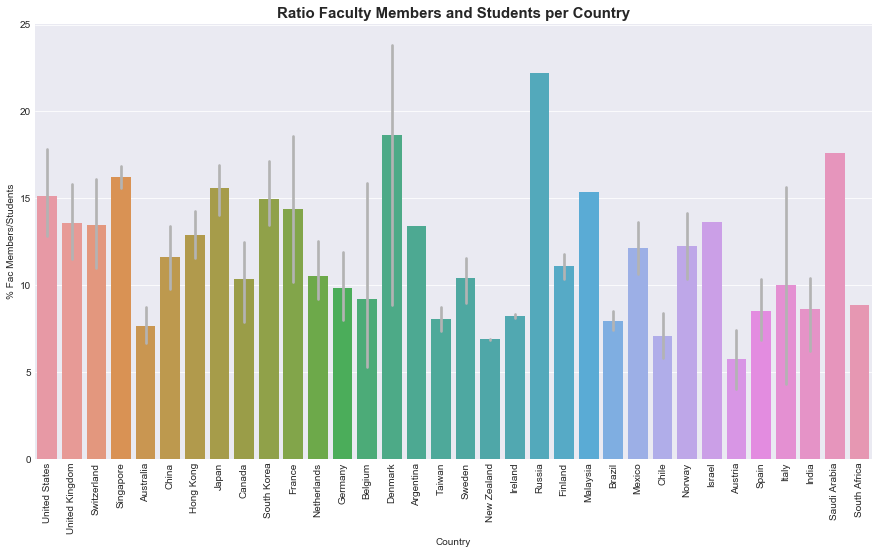

In [21]:
bars("Ratio Faculty Members and Students per Country", df_ranking, 'Country', '% Fac Members/Students')

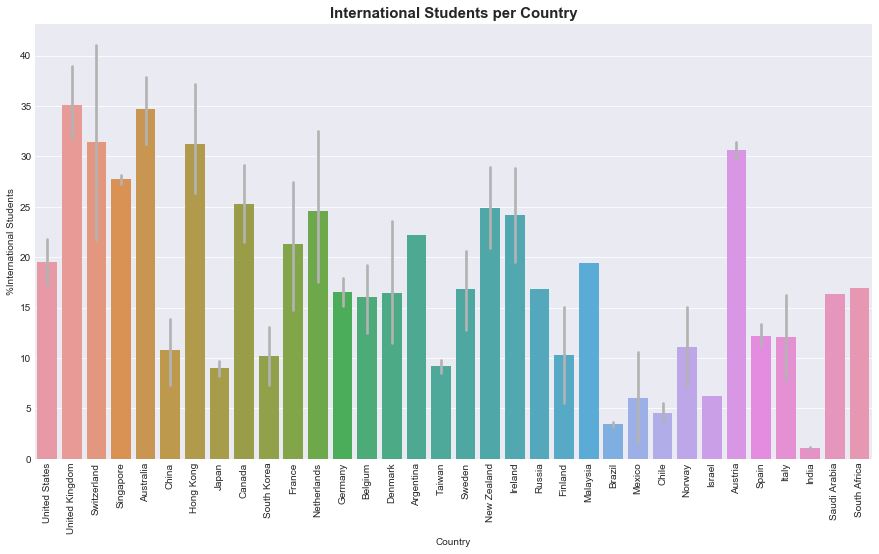

In [23]:
bars("International Students per Country", df_ranking, 'Country', '%International Students')

### d) Aggregating the data by region

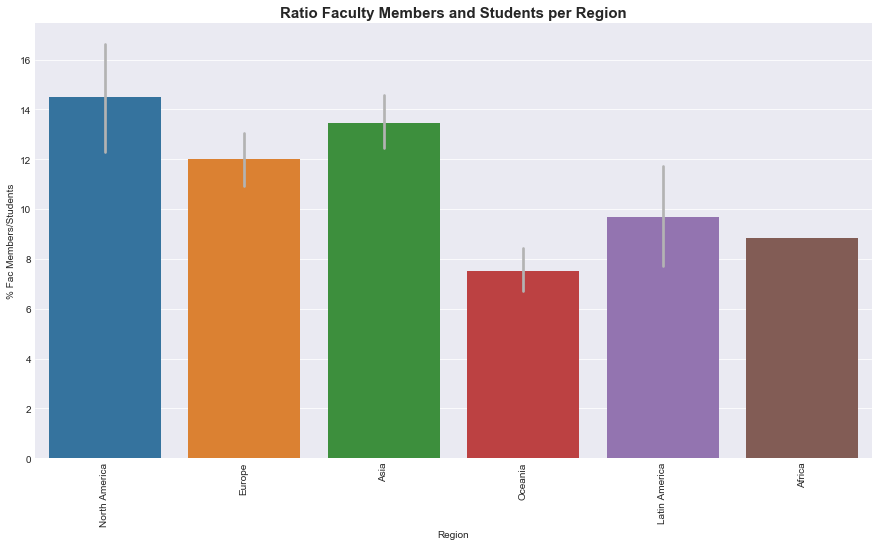

In [24]:
bars("Ratio Faculty Members and Students per Region", df_ranking, 'Region', '% Fac Members/Students')

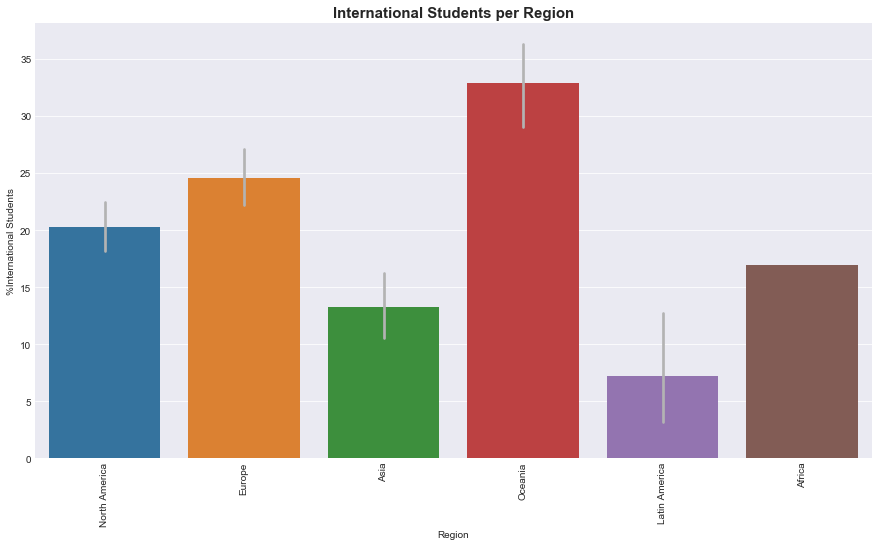

In [25]:
bars("International Students per Region", df_ranking, 'Region', '%International Students')

### Question 2

Obtain the 200 top-ranking universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)). Repeat the analysis of the previous point and discuss briefly what you observed.

Using Postman, a API request was captured on the ranking, containing a json file with all the data.

In [ ]:
times_r=requests.get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json')
data=times_r.text


We decode the json file by keeping only the first 200 data items (each data item corresponds to an university, sorting according its ranking). Furthemore, we just extract the useful columns (name, location, rank, total number of students, percentage of international students and student/staff ratio).

In [ ]:
df_times = pd.DataFrame(json.loads(data)['data'][:200],columns=['name','location','rank','stats_number_students','stats_pc_intl_students','stats_student_staff_ratio'])
df_times['stats_pc_intl_students'] = df_times['stats_pc_intl_students'].astype(str).str.replace('%','').astype(int)
df_times['stats_number_students'] = df_times['stats_number_students'].astype(str).str.replace(',','').astype(float)
df_times['stats_student_staff_ratio'] = 1/(df_times['stats_student_staff_ratio'].astype(float))
df_times.columns = ['University','Country','Rank','Total Students','% International Students','Ratio Faculties/Students']
df_times


We don't have the region information in the second website so we decide to use the information collected in the first one.

In [ ]:
conv_to_cont=df_ranking[['Country','Region']].drop_duplicates().set_index('Country')
conv_to_cont

In [ ]:
df_times_final=pd.merge(df_times, conv_to_cont,how='left',left_on="Country",right_index=True)
df_times_final['International Students'] = df_fin.apply(lambda row:row["Total Students"] * 0.01 * row["% International Students"], axis=1).round()
df_times_final['Total Faculties'] = df_fin.apply(lambda row: row["Total Students"]/row["Ratio Faculties/Students"], axis=1).round()
df_times_final
                                       

In [ ]:
bars("Ratio Faculty Members and Students per Country", df_times_final.sort_values('Country'), 'Country', 'Ratio Faculties/Students')

In [ ]:
bars("International Students per Country", df_times_final.sort_values('Country'), 'Country', '% International Students')

In [ ]:
bars("Ratio Faculty Members and Students per Region", df_times_final.sort_values('Region'), 'Region', 'Ratio Faculties/Students')

In [ ]:
bars("International Students per Region", df_times_final.sort_values('Region'), 'Region', '% International Students')

### Question 3


Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

### Question 4
Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

### Question 5

Can you find the best university taking in consideration both rankings? Explain your approach.